reference: https://bbs.huaweicloud.com/blogs/409239

## 1. 探索数据集

In [ ]:
import os

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 指定图像和标注文件夹路径

In [ ]:
PATH_IMAGE = r'D:\Tommy\++AI\++datasets\jv_radar\images_original'
PATH_MASKS = r'D:\Tommy\++AI\++datasets\jv_radar\mask'
print('图像个数', len(os.listdir(PATH_IMAGE)))
print('标注个数', len(os.listdir(PATH_MASKS)))

### 1.2 指定图像文件名

In [ ]:
file_name = 'Z9010_20230820000001Z_PPI_02_19_clean.png'
img_path = os.path.join(PATH_IMAGE, file_name)
mask_path = os.path.join(PATH_MASKS, file_name)

print('图像路径', img_path)
print('标注路径', mask_path)
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

### 1.3 可视化图像

In [ ]:
#将BGR转换成RGB，只是显示目的
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

### 1.4 mask 
- 语义分割标注，与原图大小相同，0 为 背景， 1 为 正确雷达

In [ ]:
np.unique(mask)

### 1.5 可视化语义分割标注

In [ ]:
plt.imshow(mask[:,:,0])
plt.show()

In [ ]:
# 可视化语义分割标注
plt.imshow(mask*255)
plt.show()

## 2.  可视化模板
### 2.1 可视化单张图像及其语义分割标注-代码模板

In [ ]:
plt.imshow(img1)
plt.imshow(mask*255, alpha=0.5) # alpha 高亮区域透明度，越小越接近原图
plt.title(file_name)
plt.axis('off')
plt.show()

### 2.2 可视化模板-有前景标注

In [ ]:
# n行n列可视化
n = 7

# 标注区域透明度
opacity = 0.5

fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(12,12))

i = 0

for file_name in os.listdir(PATH_IMAGE):
    
    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name)
    img1 = cv2.imread(img_path)
    img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    if 1 in mask:
        axes[i//n, i%n].imshow(img)
        axes[i//n, i%n].imshow(mask*255, alpha=opacity)
        axes[i//n, i%n].axis('off') # 关闭坐标轴显示
        i += 1
    if i > n**2-1:
        break
fig.suptitle('Image and Semantic Label', fontsize=30)
plt.tight_layout()
plt.show()

### 2.3 可视化模板-无论前景是否有标注

In [ ]:
# n行n列可视化
n = 10

# 标注区域透明度
opacity = 0.5

fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(12,12))

for i, file_name in enumerate(os.listdir(PATH_IMAGE)[:n**2]):
    
    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name)
    img1 = cv2.imread(img_path)
    img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # 可视化
    axes[i//n, i%n].imshow(img)
    axes[i//n, i%n].imshow(mask*255, alpha=opacity)
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Image and Semantic Label', fontsize=30)
plt.tight_layout()
plt.show()

## 3. 划分训练集和测试集

In [ ]:
import os
import random

### 3.1 获取全部数据文件名列表

In [ ]:
PATH_IMAGE = r'D:\Tommy\++AI\++datasets\jv_radar\images_original'

all_file_list = os.listdir(PATH_IMAGE)
all_file_num = len(all_file_list)
random.shuffle(all_file_list) # 随机打乱全部数据文件名列表

### 3.2 指定训练集和测试集比例

In [ ]:
train_ratio = 0.8
test_ratio = 1 - train_ratio
train_file_list = all_file_list[:int(all_file_num*train_ratio)]
test_file_list = all_file_list[int(all_file_num*train_ratio):]
print('数据集图像总数', all_file_num)
print('训练集划分比例', train_ratio)
print('训练集图像个数', len(train_file_list))
print('测试集图像个数', len(test_file_list))

### 3.3 生成两个txt划分文件

In [ ]:
os.mkdir(r'D:\Tommy\++AI\++datasets\jv_radar\splits')
with open(r'D:\Tommy\++AI\++datasets\jv_radar\splits\train.txt', 'w') as f:
    f.writelines(line.split('.')[0] + '\n' for line in train_file_list)
with open(r'D:\Tommy\++AI\++datasets\jv_radar\splits\val.txt', 'w') as f:
    f.writelines(line.split('.')[0] + '\n' for line in test_file_list)

## 4. MMSegmentation训练语义分割模型

In [ ]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

### 4.1 数据集图片和标注路径

In [ ]:
data_root = r'D:\Tommy\++AI\++datasets\jv_radar'
img_dir = 'images_original'
ann_dir = 'masks'

# 类别和对应的颜色
classes = ('background', 'glomeruili')
palette = [[128, 128, 128], [151, 189, 8]]

### 4.2 修改数据集类（指定图像扩展名）

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

### 4.3 自定义数据指南

url: https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data

### 4.4 修改config配置文件

- 下载 config 文件 和 预训练模型checkpoint权重文件
dos command: `mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .`

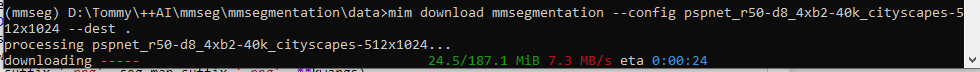
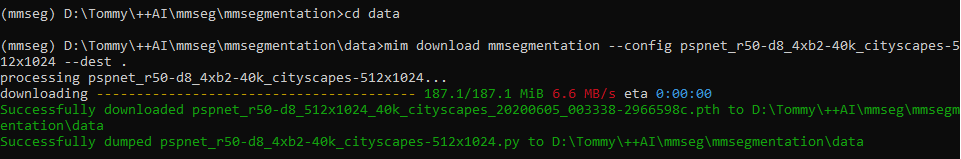
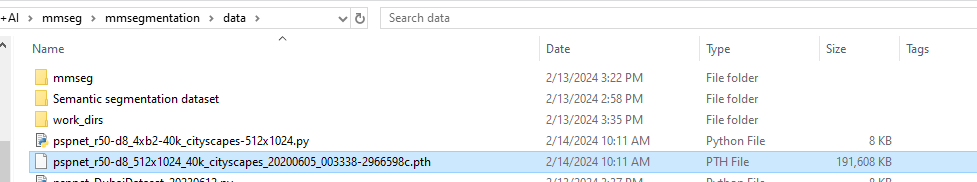

In [ ]:
from mmengine import Config
cfg = Config.fromfile(r'D:\Tommy\++AI\mmseg\mmsegmentation\configs\pspnet\pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# 修改数据集的 type 和 root
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = r'D:\Tommy\++AI\++datasets\jv_radar\splits\train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = r'D:\Tommy\++AI\++datasets\jv_radar\splits\val.txt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 工作目录
cfg.work_dir = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\jvradar'

# 训练迭代次数
cfg.train_cfg.max_iters = 800
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 400

# 随机数种子
cfg['randomness'] = dict(seed=0)


### 4.5 查看完整config配置文件, 保存config配置文件

In [ ]:
print(cfg.pretty_text)

In [ ]:
cfg.dump(r'D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\jvradar_cfg.py')

### 4.6 准备训练

In [ ]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

### 4.7 开始训练
### ** jupyter notebook有错误，无法完成，只能用pyCharm进行训练 **
- 如果遇到报错CUDA out of memeory，重启实例或使用显存更高的实例即可。

In [ ]:
#runner.train()

## 5. 用训练得到的模型预测

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

C:\Users\wangt\AppData\Local\anaconda3\envs\mmseg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 5.1 载入模型

In [2]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile(r'D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\jvradar_cfg.py')

In [3]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

02/15 12:59:35 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Quadro RTX 4000
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.55
    MSVC: n/a, reason: fileno
    PyTorch: 1.13.1
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code

d:\tommy\++ai\mmseg\mmsegmentation\mmseg\models\backbones\resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
d:\tommy\++ai\mmseg\mmsegmentation\mmseg\models\decode_heads\decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
d:\tommy\++ai\mmseg\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
d:\tommy\++ai\mmseg\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss ov

02/15 12:59:37 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/15 12:59:37 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

d:\tommy\++ai\mmseg\mmsegmentation\mmseg\engine\hooks\visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


### 5.2 初始化模型

In [4]:
# 初始化模型
checkpoint_path = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\jvradar\iter_800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\jvradar\iter_800.pth


### 5.3 载入测试集图像，或新图像

In [34]:
img = mmcv.imread(r'D:\Tommy\++AI\++datasets\jv_radar\images_original\Z9010_20230820051200Z_PPI_02_19_clean.png')
#img = mmcv.imread(r'D:\Tommy\++AI\++datasets\jv_radar\test2.png')

### 5.4 语义分割预测

In [35]:
result = inference_model(model, img)
result.keys()

['seg_logits', 'pred_sem_seg']

In [36]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
pred_mask.shape

(631, 631)

In [37]:
np.unique(pred_mask)

array([0, 1], dtype=int64)

### 5.5 可视化语义分割预测结果

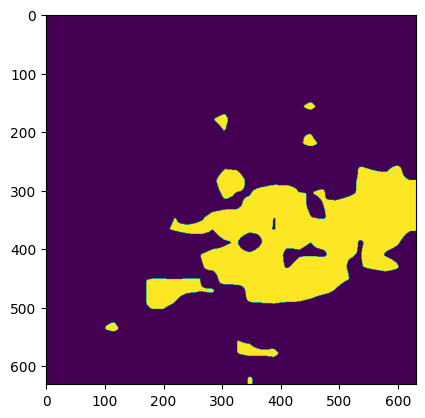

In [38]:
plt.imshow(pred_mask)
plt.show()

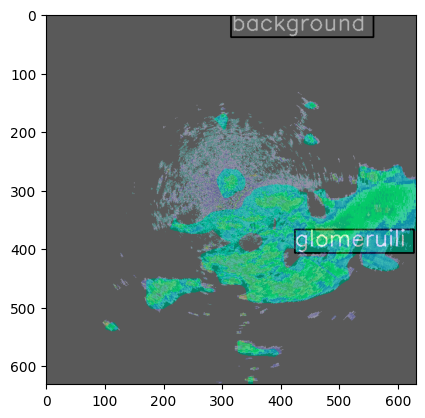

In [39]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

### 5.6 语义分割预测结果-连通域分析

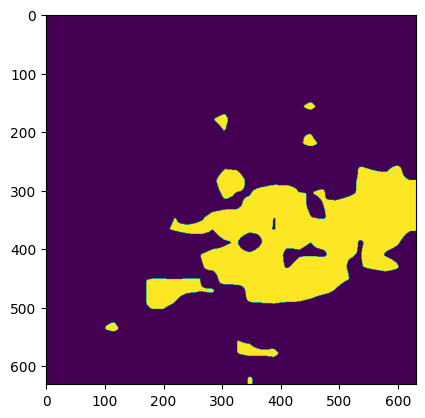

In [40]:
plt.imshow(np.uint8(pred_mask))
plt.show()

In [12]:
connected = cv2.connectedComponentsWithStats(np.uint8(pred_mask), connectivity=4)

In [13]:
# 连通域个数（第一个有可能是全图，可以忽略）
connected[0]

10

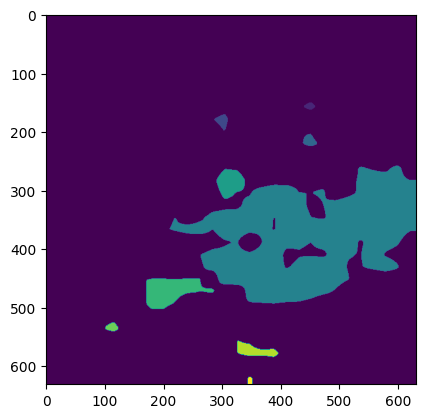

In [14]:
# 用整数表示每个连通域区域
connected[1].shape
np.unique(connected[1])
plt.imshow(connected[1])
plt.show()

In [15]:
# 每个连通域外接矩形的左上角X、左上角Y、宽度、高度、面积
connected[2]

array([[     0,      0,    631,    631, 337793],
       [   440,    151,     19,     12,    162],
       [   287,    171,     23,     28,    371],
       [   438,    204,     24,     21,    341],
       [   211,    258,    420,    236,  52681],
       [   291,    264,     48,     51,   1741],
       [   171,    451,    116,     52,   3688],
       [   101,    526,     22,     15,    237],
       [   326,    557,     70,     28,   1056],
       [   344,    619,      8,     12,     91]], dtype=int32)

In [16]:
# 每个连通域的质心坐标
connected[3]

array([[295.1939383 , 302.7923462 ],
       [449.32098765, 156.63580247],
       [300.13207547, 182.47169811],
       [449.        , 215.42521994],
       [448.11630379, 378.57225565],
       [313.90637565, 287.63469271],
       [212.12527115, 471.72640998],
       [112.10126582, 533.58227848],
       [354.91382576, 573.55113636],
       [347.47252747, 624.78021978]])

### 6. 获取测试集标注

### 6.1 加载mask图片

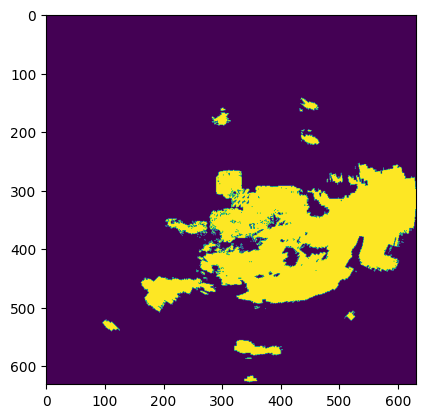

In [17]:
label = mmcv.imread(r'D:\Tommy\++AI\++datasets\jv_radar\mask\Z9010_20230820051200Z_PPI_02_19_clean.png')
label_mask = label[:,:,0]
label_mask.shape
np.unique(label_mask)
plt.imshow(label_mask)
plt.show()

### 6.2 对比测试集标注和语义分割预测结果

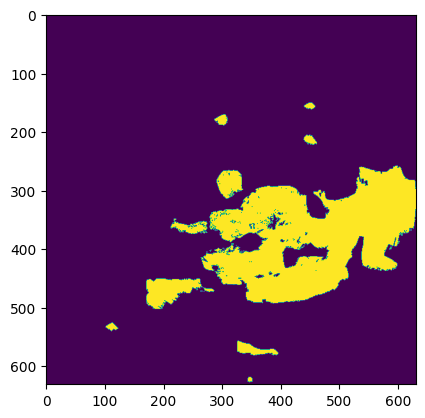

In [18]:
# 测试集标注
label_mask.shape

# 语义分割预测结果
pred_mask.shape
# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)
plt.imshow(TP)
plt.show()

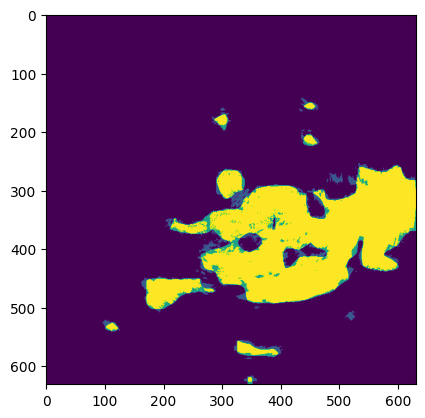

In [19]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 10
plt.imshow(confusion_map)
plt.show()

### 7. 混淆矩阵

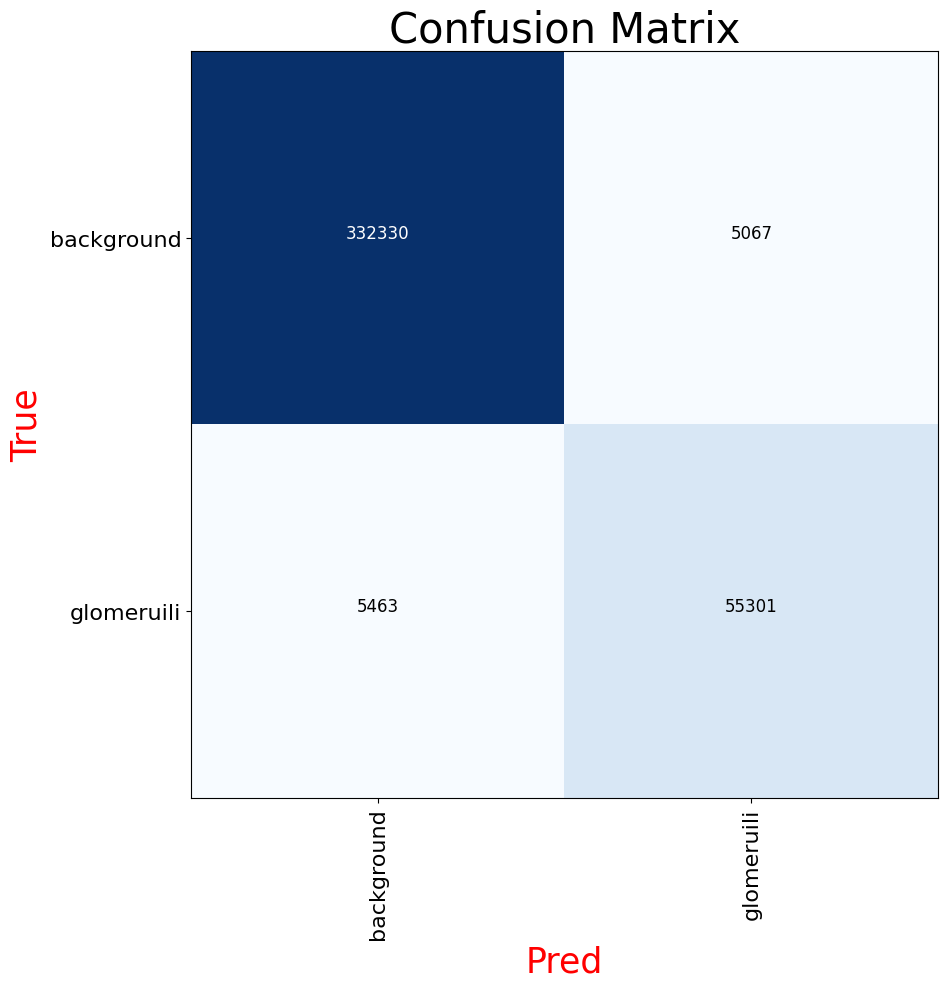

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()
classes = ('background', 'glomeruili')
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

### 9. 测试集性能评估

### 9.1 添加数据集类


- 数据集配置文件
    - `!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/StanfordBackgroundDataset.py -O ../mmsegmentation/mmseg/datasets/StanfordBackgroundDataset.py`
- 修改 ../mmsegmentation/mmseg/datasets/__init__.py，添加数据集
    - `!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/__init__.py -O ../mmsegmentation/mmseg/datasets/__init__.py`

### 9.2 测试集精度指标
`!python ../mmsegmentation/tools/test.py new_cfg.py ./work_dirs/tutorial/iter_800.pth`

### 9.3 速度指标-FPS
`!python ../mmsegmentation/tools/analysis_tools/benchmark.py new_cfg.py ./work_dirs/tutorial/iter_800.pth`

### 10 Code Running in pyCharm for training

In [ ]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt

from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

from mmengine import Config

from mmengine.runner import Runner
from mmseg.utils import register_all_modules

data_root = r'D:\Tommy\++AI\++datasets\jv_radar'
img_dir = 'images_original'
ann_dir = 'mask'

# 类别和对应的颜色
classes = ('background', 'glomeruili')
palette = [[128, 128, 128], [151, 189, 8]]

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

if __name__ == '__main__':
    cfg = Config.fromfile(r'D:\Tommy\++AI\mmseg\mmsegmentation\configs\pspnet\pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
    cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
    cfg.crop_size = (256, 256)
    cfg.model.data_preprocessor.size = cfg.crop_size
    cfg.model.backbone.norm_cfg = cfg.norm_cfg
    cfg.model.decode_head.norm_cfg = cfg.norm_cfg
    cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
    # modify num classes of the model in decode/auxiliary head
    cfg.model.decode_head.num_classes = 2
    cfg.model.auxiliary_head.num_classes = 2

    # 修改数据集的 type 和 root
    cfg.dataset_type = 'StanfordBackgroundDataset'
    cfg.data_root = data_root

    cfg.train_dataloader.batch_size = 8

    cfg.train_pipeline = [
        dict(type='LoadImageFromFile'),
        dict(type='LoadAnnotations'),
        dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
        dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
        dict(type='RandomFlip', prob=0.5),
        dict(type='PackSegInputs')
    ]

    cfg.test_pipeline = [
        dict(type='LoadImageFromFile'),
        dict(type='Resize', scale=(320, 240), keep_ratio=True),
        # add loading annotation after ``Resize`` because ground truth
        # does not need to do resize data transform
        dict(type='LoadAnnotations'),
        dict(type='PackSegInputs')
    ]


    cfg.train_dataloader.dataset.type = cfg.dataset_type
    cfg.train_dataloader.dataset.data_root = cfg.data_root
    cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
    cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
    cfg.train_dataloader.dataset.ann_file = r'D:\Tommy\++AI\++datasets\jv_radar\splits\train.txt'

    cfg.val_dataloader.dataset.type = cfg.dataset_type
    cfg.val_dataloader.dataset.data_root = cfg.data_root
    cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
    cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
    cfg.val_dataloader.dataset.ann_file = r'D:\Tommy\++AI\++datasets\jv_radar\splits\val.txt'

    cfg.test_dataloader = cfg.val_dataloader


    # 载入预训练模型权重
    cfg.load_from = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

    # 工作目录
    cfg.work_dir = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\jvradar'

    # 训练迭代次数
    cfg.train_cfg.max_iters = 800
    # 评估模型间隔
    cfg.train_cfg.val_interval = 400
    # 日志记录间隔
    cfg.default_hooks.logger.interval = 100
    # 模型权重保存间隔
    cfg.default_hooks.checkpoint.interval = 400

    # 随机数种子
    cfg['randomness'] = dict(seed=0)


    # register all modules in mmseg into the registries
    # do not init the default scope here because it will be init in the runner
    register_all_modules(init_default_scope=False)
    runner = Runner.from_cfg(cfg)

    runner.train()

